In [29]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yfin
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [32]:
# import data
yfin.pdr_override()

def get_data(stocks, start, end):
    df = pdr.get_data_yahoo(stocks, start, end)
    return df

stock = ['^GSPC']
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)
stock_prices = get_data(stock, startDate, endDate)
print(startDate)
stock_prices.head()


[*********************100%***********************]  1 of 1 completed
2004-02-26 18:15:37.595784


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-02-26,1143.670044,1147.229980,1138.619995,1144.910034,1144.910034,1383900000
2004-02-27,1145.800049,1151.680054,1141.800049,1144.939941,1144.939941,1540400000
2004-03-01,1144.939941,1157.449951,1144.939941,1155.969971,1155.969971,1497100000
2004-03-02,1155.969971,1156.540039,1147.310059,1149.099976,1149.099976,1476000000
2004-03-03,1149.099976,1152.439941,1143.780029,1151.030029,1151.030029,1334500000


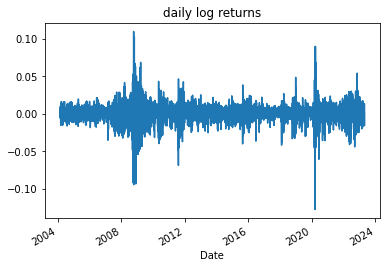

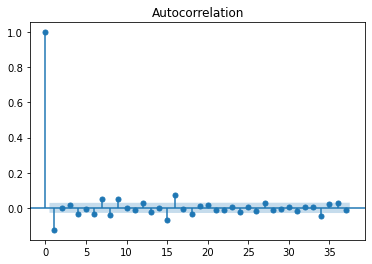

In [33]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

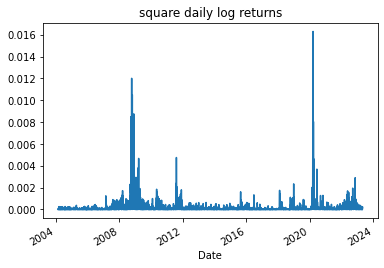

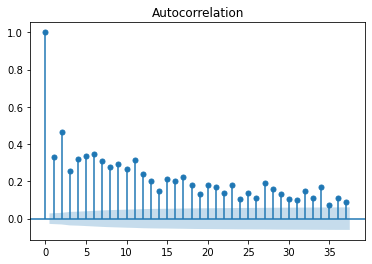

In [34]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

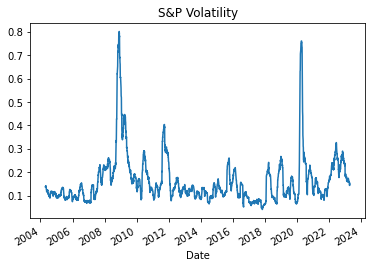

In [37]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('S&P Volatility')
plt.show()

In [38]:
# Maximum Log-likelihood Estimation (MLE)

In [41]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat,2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [43]:
# Performing MLE numerically

In [48]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]
    
    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )
    
    return -l_theta
def sigma_pos(theta):
    sigma = theta[1]
    return sigma

cons_set = {'type':'ineq', 'fun': sigma_pos}

theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x,), constraints=cons_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1],2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


C:\Users\DARCHI~1\AppData\Local\Temp/ipykernel_13512/1878625638.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [49]:
# MLE of Ornstein-Uhlenbeck process

In [54]:
def mu(x,dt,kappa,theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt,kappa,sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*(1-e2kt)/(2*kappa)

def log_likelihood_OU(theta_hat,x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]
    
    x_dt = x[1:]
    x_t = x[:-1]
    
    dt = 1/252
    
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )
    
    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[1]
    return sigma

vol = np.array(volatility)

cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)

kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


C:\Users\DARCHI~1\AppData\Local\Temp/ipykernel_13512/936324673.py:22: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.152


In [55]:
# Simulating Ornstein-Uhlenbeck process:

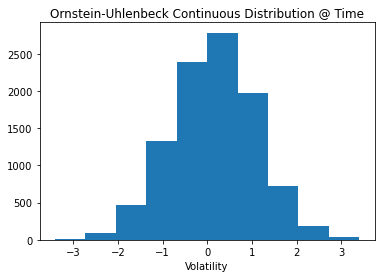

In [59]:
# define parameters
Time = 0.3
M = 10000

Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ Time')
plt.xlabel('Volatility')
plt.show()

In [60]:
# Discretised SDE 

In [61]:
# Initializse parameters for discretization
days = 1
years = 2

dt = days/252

M =  1000
N = int(years/dt)

Execution time 0.05395174026489258


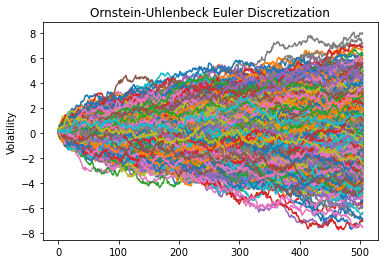

In [65]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

def OU_recursive(t, vol_OU):
    # Return the final state
    if t == N:
        return vol_OU
    
    # Thread the state through the recursive call
    else:
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t + 1, vol_OU)
    
    
start_time = time.time() 
vol_OU = OU_recursive(0, vol_OU)
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

In [66]:
# Python Loop

Execution time 0.0419621467590332


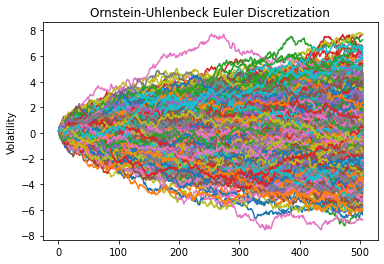

In [67]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)

vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()